# Tâche 3 - Corriger des proverbes avec des *transformers*

Tout comme pour le premier travail pratique, l'objectif de cette tâche est de corriger des proverbes. Cependant vous devrez choisir et utiliser des modèles transformers (2) pour identifier le mot à remplacer et choisir le meilleur mot à insérer en fonction du contexte du proverbe. 


Consignes : 
- Corriger un proverbe consiste à remplacer un verbe par l’un des mots proposés dans la liste. 
- Choix des modèles transformer: Vous devrez choisir 2 modèles, un pour faire l’analyse grammaticale (*POS tagging*) et l'autre pour choisir le mot à insérer dans le proverbe. Deux contraintes : a) pas de LLMs, et b) utilisez des modèles de HuggingFace qui peuvent traiter le français (ou qui sont multilingues). 
- Entraînement des modèles : Vous pouvez utiliser les modèles préentraînés sans modification. Me consulter en cas de doute.  
- Segmentation : Ne pas segmenter un proverbe en sous-phrases. 
- Tokenisation et plongements de mots : Ceux des modèles utilisés. 
- Prétraitement et normalisation : Rien à faire. 
- Code : Utilisez le fichier ***t3_corriger_proverbes.ipynb*** (ce fichier) pour mener vos expérimentations. 
- Données : Évaluez la performance à l’aide du fichier ***data/t3_test_proverbes.json*** et faire l'analyse de vos résultats. 
- Question : Comment se compare l’approche retenue pour cette tâche par rapport à celle du Travail pratique #1?

Vous pouvez ajouter au *notebook* toutes les cellules dont vous avez besoin pour votre code, vos explications ou la présentation de vos résultats. Vous pouvez également ajouter des sous-sections (par ex. des sous-sections 1.1, 1.2 etc.) si cela améliore la lisibilité.

Notes :
- Évitez les bouts de code trop longs ou trop complexes. Par exemple, il est difficile de comprendre 4-5 boucles ou conditions imbriquées. Si c'est le cas, définissez des sous-fonctions pour refactoriser et simplifier votre code. 
- Expliquez sommairement votre démarche.
- Expliquez les choix que vous faites au niveau de la programmation et des modèles (si non trivial).
- Analyser vos résultats. Indiquez ce que vous observez, si c'est bon ou non, si c'est surprenant, etc. 
- Une analyse quantitative et qualitative d'erreurs est intéressante et permet de mieux comprendre le comportement d'un modèle.

## Import des librairies

In [1]:
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
import torch
from copy import deepcopy
import logging

from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from transformers import CamembertForMaskedLM, CamembertTokenizer

logging.getLogger("transformers").setLevel(logging.WARNING)

/home/nibou/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-14 20:56:33.984443: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 20:56:35.389089: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Section 1 - Lecture du fichier de test 

Le fichier de test ***./data/t3_test_proverbes.json*** contient les proverbes modifiés, la liste de mots candidats et la bonne version du proverbe. 

In [2]:
def load_tests(filename):
    with open(filename, 'r', encoding='utf-8') as fp:
        test_data = json.load(fp)
    return test_data

In [3]:
test_fn = './data/t3_test_proverbes.json'  # Le fichier de test = À modifier selon votre configuration

In [4]:
tests = load_tests(test_fn)

In [5]:
def get_dataframe(test_proverbs):
    return pd.DataFrame.from_dict(test_proverbs, orient='columns', dtype=None, columns=None)

df = get_dataframe(tests)
df

,Masked,Word_list,Proverb
0,a beau mentir qui part de loin,"[vient, revient]",a beau mentir qui vient de loin
1,a beau dormir qui vient de loin,"[partir, mentir]",a beau mentir qui vient de loin
2,l’occasion forge le larron,"[fait, occasion]",l’occasion fait le larron
3,"endors-toi, le ciel t’aidera","[bouge, aide]","aide-toi, le ciel t’aidera"
4,"aide-toi, le ciel t’aura","[aidera, aide]","aide-toi, le ciel t’aidera"
5,"ce que femme dit, dieu le veut","[dit, veut]","ce que femme veut, dieu le veut"
6,"ce que femme veut, dieu le souhaite","[dit, veut]","ce que femme veut, dieu le veut"
7,bien mal acquis ne sait jamais,"[profite, fait]",bien mal acquis ne profite jamais
8,bon ouvrier ne déplace pas ses outils,"[fait, querelle]",bon ouvrier ne querelle pas ses outils
9,"pour le fou, c’était tous les jours fête","[est, es]","pour le fou, c’est tous les jours fête"


## Section 2 - Code pour repérer les mots qui pourraient être remplacés dans un proverbe modifié

Expliquez ici comment vous procédez pour identifier les mots d'un proverbe qui pourraient faire l'objet d'une substitution.  



#### Loading POS-Tagging Model

In [6]:
"""
Source : https://huggingface.co/gilf/french-camembert-postag-model
"""

tokenizer = AutoTokenizer.from_pretrained("gilf/french-camembert-postag-model") # modèle CamemBERT pour le POS tagging
model = AutoModelForTokenClassification.from_pretrained("gilf/french-camembert-postag-model")
nlp_token_class = pipeline('ner', model=model, tokenizer=tokenizer, grouped_entities=True, device=0)

Some weights of the model checkpoint at gilf/french-camembert-postag-model were not used when initializing CamembertForTokenClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing CamembertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/nibou/.local/lib/python3.10/site-packages/transformers/pipelines/token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="simple"` instead.
  warnings.warn(


#### Fonction pour retrouver les verbes

In [7]:
def get_verbs(proverb):

    """
    Cette fonction permet de récupérer les verbes d'un proverbe donné et de les masquer.
    Input : proverb (str) : le proverbe à traiter
    Output : verbs (list) : la liste des verbes du proverbe
             masked_proverbs (list) : la liste des proverbes masqués
    """

    results = nlp_token_class(proverb) # On récupère les entités nommées
    masked_proverbs = []
    verbs = []

    for result in results: # On récupère les verbes
        if result['entity_group'] == 'V' or result['entity_group'] == 'VIMP' or result['entity_group'] == 'VINF' or result['entity_group'] == 'VS' or result['entity_group'] == 'VPP' or result['entity_group'] == 'VPR' or result['entity_group'] == 'VS':
                
            verbs.append(result['word'])

            start_pos = result['start']
            end_pos = result['end']
            # on remplace le verbe par <mask>
            masked_proverb = proverb[:start_pos] + '<mask>' + proverb[end_pos:]
            masked_proverbs.append(masked_proverb)
    

    return verbs, masked_proverbs

#### Exemple d'utilisation

In [8]:
proverb = "endors-toi, le ciel t'aidera"
verbs, masked_proverbs = get_verbs(proverb)
tokens = tokenizer.tokenize(proverb)

print(masked_proverbs)
print(verbs)
print(tokens)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


["<mask>dors-toi, le ciel t'aidera", "en<mask>toi, le ciel t'aidera", "endors-toi, le ciel t'<mask>"]
['en', 'dors-', 'aidera']
['▁en', 'dor', 's', '-', 'toi', ',', '▁le', '▁ciel', '▁t', "'", 'aider', 'a']


## Section 3 - Modèle et code pour corriger un proverbe

Expliquez ici comment vous procédez pour choisir la meilleure version parmi les proverbes modifiés. 

### Choix du transformer

In [9]:
model_name = "camembert-base"
model = CamembertForMaskedLM.from_pretrained(model_name)
tokenizer = CamembertTokenizer.from_pretrained(model_name)
#camembert_fill_mask  = pipeline("fill-mask", model=model, tokenizer=tokenizer, device=0)
camembert_fill_mask  = pipeline("fill-mask", model="camembert/camembert-base-wikipedia-4gb", tokenizer="camembert/camembert-base-wikipedia-4gb")

# Mettre le modèle en mode évaluation et déplacer vers GPU si disponible
model.eval()

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing CamembertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


CamembertForMaskedLM(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0): CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

#### Exemple d'utilisation

In [10]:
results = camembert_fill_mask("a beau mentir qui <mask> de loin", top_k=10) # On récupère les 10 premières prédictions
print(results)

[{'score': 0.4843288064002991, 'token': 3966, 'token_str': 'parle', 'sequence': 'a beau mentir qui parle de loin'}, {'score': 0.23671703040599823, 'token': 1531, 'token_str': 'vient', 'sequence': 'a beau mentir qui vient de loin'}, {'score': 0.07290150225162506, 'token': 778, 'token_str': 'va', 'sequence': 'a beau mentir qui va de loin'}, {'score': 0.027419500052928925, 'token': 2133, 'token_str': 'revient', 'sequence': 'a beau mentir qui revient de loin'}, {'score': 0.025926366448402405, 'token': 15406, 'token_str': 'parlent', 'sequence': 'a beau mentir qui parlent de loin'}, {'score': 0.02402493730187416, 'token': 5416, 'token_str': 'provient', 'sequence': 'a beau mentir qui provient de loin'}, {'score': 0.021882593631744385, 'token': 23, 'token_str': 'est', 'sequence': 'a beau mentir qui est de loin'}, {'score': 0.016047585755586624, 'token': 2684, 'token_str': 'arrive', 'sequence': 'a beau mentir qui arrive de loin'}, {'score': 0.009811180643737316, 'token': 760, 'token_str': 'dit'

### Correction du proverbe

In [11]:
def is_infinitive_verb(verb):
     
    """
    Cette fonction permet de vérifier si un verbe est à l'infinitif
    Input : verb (str) : le verbe à vérifier
    Output : (bool) : True si le verbe est à l'infinitif, False sinon
    """

    results = nlp_token_class(verb) # On récupère les entités nommées
    for result in results:
        if result['entity_group'] == 'VINF':
            return True
    return False

def post_process(proverb):
    """
    Cette fonction permet de corriger les proverbes en sortie du modèle CamemBERT
    Elle supprime les espaces avant les virgules et après les apostrophes

    Input : proverb (str) : le proverbe à corriger
    Output : proverb (str) : le proverbe corrigé
    """

    proverb = proverb.replace("' ", "'")
    proverb = proverb.replace(" ,", ",")
    proverb = proverb.replace("’ ", "’")
    proverb = proverb.replace(" -", "-")

    return proverb
    

def correct_proverb(proverb, word_list, post_processing=True, inf_verb=True):
    """
    Cette fonction permet de corriger un proverbe en remplaçant un mot masqué par un mot de la liste word_list
    Input :  proverb (str) : le proverbe à corriger
             word_list (list) : la liste de verbes candidats pour le remplacement
    Output : best_prob (float) : la probabilité du proverbe corrigé
             best_position (int) : la position du mot corrigé dans la liste des tokens
             best_proverb (str) : le proverbe corrigé
    """

    best_prob = 0
    best_position = 0
    best_proverb = ""

    verbs, masked_proverbs = get_verbs(proverb)
    for i,sentence in enumerate(masked_proverbs):
        
        results = camembert_fill_mask(sentence, top_k=2000) # On récupère les 1000 meilleures prédictions du modèle pour chaque mot masqué
        tokens_text = [result['token_str'] for result in results]
        probs = [result['score'] for result in results]
        sequences = [result['sequence'] for result in results]

        # On cherche le meilleur verbe candidat parmis les prédictions du modèle
        for word in word_list:
            if word in tokens_text:
                
                if inf_verb:
                    if (is_infinitive_verb(verbs[i]) and not is_infinitive_verb(word)) or (not is_infinitive_verb(verbs[i]) and is_infinitive_verb(word)):
                        continue

                if verbs[i] == word:
                    continue

                word_index = tokens_text.index(word)
                if probs[word_index] > best_prob:
                    best_prob = probs[word_index]
                    best_position = word_index
                    best_proverb = sequences[word_index]

                    #post processing
                    if post_processing:
                        best_proverb = post_process(best_proverb)
                    
    return best_prob, best_position, best_proverb  
            

#### Exemple d'utilisation

In [12]:
false_proverb = "a beau dormir qui vient de loin"
true_proverb = "a beau mentir qui vient de loin"
candidate_words = ["partir","mentir"]

best_prob, best_position, best_proverb = correct_proverb(false_proverb, candidate_words)

print(f"La meilleure probabilité est {best_prob}")
print(f"La meilleure position est {best_position}")
print(f"Le proverbe corrigé est : {best_proverb}")

La meilleure probabilité est 9.370876068715006e-05
La meilleure position est 339
Le proverbe corrigé est : a beau partir qui vient de loin


## Section 4 - Expérimentations et analyse de résultats


### Présentation du meilleur résultat sous forme de dataframe

* La colonne **Masked** correspond au proverbe qui a été modifié
* La colonnne **Verbe_Founded** correspond aux verbes qui ont été trouvé par Spacy
* La colonne **Word_list** correspond aux deux verbes que notre programme doit choisir et remplacer au bon endroit dans le proverbe pour que celui-ci soit corrigé
* La colonne **Proverb** représente la solution
* La colonne **Our_proverb** est le résultat renvoyé par notre programme
* La colonne **Score** nous renvoit le score de perplexité ou logprob (à choisir) qu'a obtenu notre résultat
* La colonne **Equal** nous dit si notre résultat est équivalent à la solution

In [13]:
df_results = pd.DataFrame(columns=['Masked', 'Verb_Founded', 'Word_list', 'Proverb', 'Our_proverb', 'Score','Equal'])

def results(df_results, post_processing=False, infinitive_with_infinitive=False):
    score = 0
    for _, row in df.iterrows():

        our_proverb = correct_proverb(row['Masked'], row['Word_list'], post_processing, infinitive_with_infinitive)
        verbs, _ = get_verbs(row['Masked'])

        if our_proverb[2] == row['Proverb']:
            score += 1
            df_results.loc[len(df_results)] = {'Masked': row['Masked'], 'Verb_Founded': verbs, 'Word_list': row['Word_list'], 'Proverb': row['Proverb'], 'Our_proverb': our_proverb[2], 'Score': our_proverb[0], 'Equal': True}
        else:
            df_results.loc[len(df_results)] = {'Masked': row['Masked'], 'Verb_Founded': verbs, 'Word_list': row['Word_list'], 'Proverb': row['Proverb'], 'Our_proverb': our_proverb[2], 'Score': our_proverb[0], 'Equal': False}
        
    return score

score = results(df_results)
print(f"Score : {score}/{len(df)}")
print(f"Pourcentage de réussite : {score/len(df)*100}%")
#df_results

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Score : 9/26
Pourcentage de réussite : 34.61538461538461%


Le score obtenu pour un le modèle *camembert/camembert-base-wikipedia-4gb* est de 9/26 (34%) ce qui est déjà pas mal mais on peut améliorer cela:

* En changeant de modèle et en prenant un modèle basé sur plus données de texte, comme *camembert-base* qui est entrainé sur 138 gB de données textuelles (OSCAR)
* En analysant certaines erreurs, on remarque que le proverbe est correct mais des espaces ont été rajoutés à certains endroits, ce qui rend la comparaison incorrecte. Pour palier à cela, on peut faire du **post-processing** qui nous permettra d'enlever certains espaces
* Parfois, notre algorithme va remplacer un verbe à l'infinitif par un verbe conjugué. Pour palier à cela, on ajoute une condition dans notre programme.

Le graphe suivant nous permet de comparer les différents scores avec les améliorations du modèle

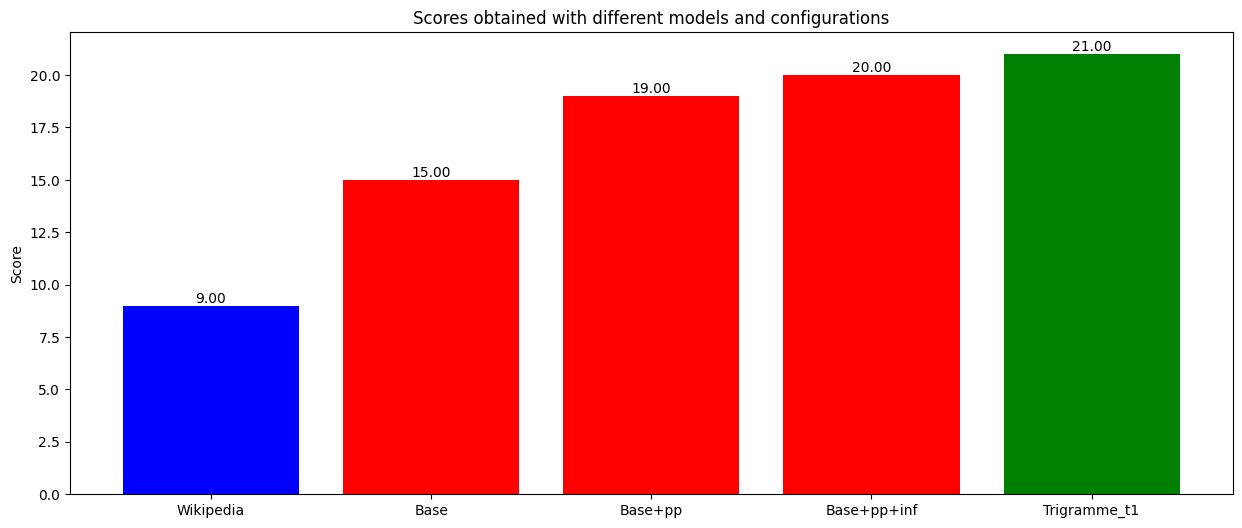

In [14]:
camembert_fill_mask  = pipeline("fill-mask", model=model, tokenizer=tokenizer, device=0)

df_results1 = pd.DataFrame(columns=['Masked', 'Verb_Founded', 'Word_list', 'Proverb', 'Our_proverb', 'Score','Equal'])
score1 = results(df_results1)

post_processing = True
df_results2 = pd.DataFrame(columns=['Masked', 'Verb_Founded', 'Word_list', 'Proverb', 'Our_proverb', 'Score','Equal'])
score2 = results(df_results2, post_processing=post_processing)

infinitive_with_infinitive = True
df_results3 = pd.DataFrame(columns=['Masked', 'Verb_Founded', 'Word_list', 'Proverb', 'Our_proverb', 'Score','Equal'])
score3 = results(df_results3, post_processing=post_processing, infinitive_with_infinitive=infinitive_with_infinitive)

scores = [score, score1, score2, score3,21]
labels = ['Wikipedia', 'Base', 'Base+pp' , 'Base+pp+inf','Trigramme_t1']

figure = plt.figure(figsize=(15, 6))
bars = plt.bar(labels, scores, color=['blue', 'red', 'red', 'red','green'])

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{score:.2f}', ha='center', va='bottom')

plt.ylabel('Score')
plt.title('Scores obtained with different models and configurations')
plt.show()

On remarque une nette amélioration entre le modèle basée sur Wikipédia et celui sur OSCAR. Cela vient du fait que le deuxième modèle a été entrainé sur plus de données d'entrainement, ce qu'il lui permet de mieux capturer la langue français et de calculer des probabilités plus précises et adéquates.

Notre post-processing et notre gestion des temps des verbes nous permet d'aller chercher un score de 20/26, soit 76% d'Accuracy

Cependant, le résultat est quand même loin d'être parfait. Cela peut venir du fait que notre transformer est basé sur des textes plus classiques de la langue française. Le fait que certains proverbes apparaissent rarement dans la littérature, et que certaines combinaisons de mots semblent "illogiques" d'un point de vue probabiliste (ex: Bon ouvrier ne querelle pas ses outils; le verbe quereller apparait très rarement le mot outil dans la langue française) rend la tâche compliquée pour le transformer. Une analyse plus précise des erreurs est disponible dans la section suivante.

Si on compare à notre résultat obtenu au travail 1, nous avons réussi à atteindre quasiment le même score, mais pas tout à fait. Cela est probablement du au fait que le Trigram était spécifiquement entrainé sur des proverbes et qu'il est arrivé à bien comprendre la structure de ceux-ci. 

### Analyse des erreurs

On peut voir dans le tableau suivant les différents proverbes qui ont causés des problèmes à notre programme

In [15]:
df_incorrect = df_results3[df_results3['Equal'] == False].copy()
df_incorrect

,Masked,Verb_Founded,Word_list,Proverb,Our_proverb,Score,Equal
3,"endors-toi, le ciel t’aidera","[en, dors-, aidera]","[bouge, aide]","aide-toi, le ciel t’aidera","en aide toi, le ciel t’aidera",0.020798,False
4,"aide-toi, le ciel t’aura","[aide, -, aura]","[aidera, aide]","aide-toi, le ciel t’aidera","aide-toi, le ciel t’aide",0.300875,False
8,bon ouvrier ne déplace pas ses outils,[déplace],"[fait, querelle]",bon ouvrier ne querelle pas ses outils,bon ouvrier ne fait pas ses outils,0.003076,False
18,on ne mord pas le poisson qui est encore dans ...,"[mord, est]","[vend, dit]",on ne vend pas le poisson qui est encore dans ...,on ne dit pas le poisson qui est encore dans l...,0.002110,False
20,le poisson mange par la tête,[mange],"[pourrit, respire]",le poisson pourrit par la tête,le poisson respire par la tête,0.000375,False
21,"repose-toi plutôt sans souper, que de te lever...","[repose, -, souper, lever]","[lève, couche]","couche-toi plutôt sans souper, que de te lever...","lève-toi plutôt sans souper, que de te lever a...",0.295070,False


Pour voir qu'est ce qu'il s'est passé, nous allons créer une dataframe avec toutes les solutions par lequel notre programme est passé.

In [16]:
df_incorrect_all_values = pd.DataFrame(columns=['Number', 'Masked', 'Our_proverb', 'Good_Proverb', 'Prob', 'Position', 'Equal'])

def correct_proverb_analysis(proverb, word_list, number, answer):
    """
    Cette fonction permet de corriger un proverbe en remplaçant un mot masqué par un mot de la liste word_list
    Input :  proverb (str) : le proverbe à corriger
             word_list (list) : la liste de verbes candidats pour le remplacement
    Output : best_prob (float) : la probabilité du proverbe corrigé
             best_position (int) : la position du mot corrigé dans la liste des tokens
             best_proverb (str) : le proverbe corrigé
    """

    verbs, masked_proverbs = get_verbs(proverb)
    for i,sentence in enumerate(masked_proverbs):
        
        results = camembert_fill_mask(sentence, top_k=1000) # On récupère les 1000 meilleures prédictions du modèle pour chaque mot masqué
        tokens_text = [result['token_str'] for result in results]
        probs = [result['score'] for result in results]
        sequences = [result['sequence'] for result in results]

        # On cherche le meilleur verbe candidat parmis les prédictions du modèle
        for word in word_list:
            if word in tokens_text:
                
                if (is_infinitive_verb(verbs[i]) and not is_infinitive_verb(word)) or (not is_infinitive_verb(verbs[i]) and is_infinitive_verb(word)):
                    continue

                if verbs[i] == word:
                    continue

                word_index = tokens_text.index(word)
                prob = probs[word_index]
                position = word_index
                modified_proverb = sequences[word_index]
                
                #post processing
                modified_proverb = post_process(modified_proverb)

                df_incorrect_all_values.loc[len(df_incorrect_all_values)] = {'Number': number, 'Masked': proverb, 'Our_proverb': modified_proverb, 'Good_Proverb': answer, 'Prob': prob, 'Position': position, 'Equal': modified_proverb == answer}
                    
    return 

for i, row in df_incorrect.iterrows():
    correct_proverb_analysis(row['Masked'], row['Word_list'], i, row['Proverb'])

df_incorrect_all_values

,Number,Masked,Our_proverb,Good_Proverb,Prob,Position,Equal
0,3,"endors-toi, le ciel t’aidera","bouge dors-toi, le ciel t’aidera","aide-toi, le ciel t’aidera",0.000053,818,False
1,3,"endors-toi, le ciel t’aidera","aide dors-toi, le ciel t’aidera","aide-toi, le ciel t’aidera",0.000129,407,False
2,3,"endors-toi, le ciel t’aidera","en aide toi, le ciel t’aidera","aide-toi, le ciel t’aidera",0.020798,5,False
3,3,"endors-toi, le ciel t’aidera","endors-toi, le ciel t’aide","aide-toi, le ciel t’aidera",0.002975,44,False
4,4,"aide-toi, le ciel t’aura","aidera-toi, le ciel t’aura","aide-toi, le ciel t’aidera",0.000176,506,False
5,4,"aide-toi, le ciel t’aura","aide aidera toi, le ciel t’aura","aide-toi, le ciel t’aidera",0.000017,592,False
6,4,"aide-toi, le ciel t’aura","aide aide toi, le ciel t’aura","aide-toi, le ciel t’aidera",0.000793,46,False
7,4,"aide-toi, le ciel t’aura","aide-toi, le ciel t’aidera","aide-toi, le ciel t’aidera",0.211384,1,True
8,4,"aide-toi, le ciel t’aura","aide-toi, le ciel t’aide","aide-toi, le ciel t’aidera",0.300875,0,False
9,8,bon ouvrier ne déplace pas ses outils,bon ouvrier ne fait pas ses outils,bon ouvrier ne querelle pas ses outils,0.003076,37,False


Concernant les erreurs, on peut trouver des raisons pour lesquelles notre modèle s'est trompé:

* 3) Notre modèle NER n'a pas réussi à bien captuer le verbe *endors*           (le travail 1 s'était également trompé sur ce proverbe)
* 4) Le bon proverbe est à la seconde place dans l'ordre des probabilités       (le travail 1 s'était également trompé sur ce proverbe)
* 8) Le modèle ne possède pas le mot querelle dans son vocabulaire              (le travail 1 s'était également trompé sur ce proverbe)
* 18) Le bon proverbe est la seconde option avec la probabilité la plus élevée
* 20) Le modèle ne possède pas le mot pourrit dans son vocabulaire
* 21) Le bon proverbe est la seconde option avec la probabilité la plus élevée  (le travail 1 s'était également trompé sur ce proverbe)